# Part 1: EDA, Dimensionality Reduction, and Clustering

Scenario: You have been asked to analyze a text dataset consisting of information from Maine legislative bills. The dataset has the following features:

- `ld_number`: A unique identifier for each bill.
- `title_embedding`: A pre-computed embedding of the bill's title. (We will learn more about embeddings later in the semester.)
- `text_embedding`: A pre-computed embedding of the bill's full text.

Your first task is to perform exploratory data analysis (EDA) on the dataset using dimensionality reduction techniques and clustering algorithms to try and identify any patterns or groupings in the data.

**For this notebook, use only the `title_embedding` features.** You will compare title vs. text embeddings in later notebooks.

In [2]:
import numpy as np  #importing all the packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from umap import UMAP

In [3]:
X = pd.read_json('data/X.json')  #reading the embedded .jason file
title_embeddings = np.array(X['title_embedding'].tolist())#Extracts the title_embeddings and adds it to a list
scaler = StandardScaler() #Brings the embeddings to a standard scale
title_embeddings_std = scaler.fit_transform(title_embeddings)


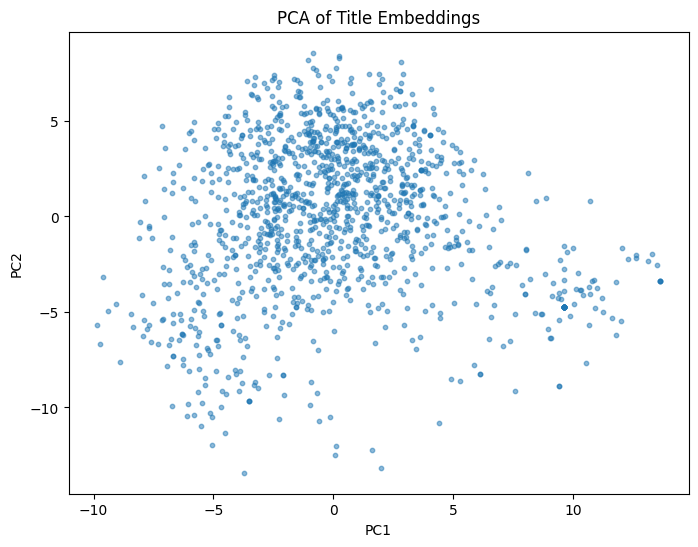

In [ ]:
#Performming principal component analysis to bring the data down exactly to 2 components and then representing them as a scatter plots 
#constructing the pca graph with 2d and random state 42 and then fit the data and representaing them.
pca = PCA(n_components=2, random_state=42) 
pca_embeddings = pca.fit_transform(title_embeddings_std)
plt.figure(figsize=(8, 6))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5, s=10)
plt.title('PCA of Title Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
#The Pca graph shows us the text data is complex and messay and linear techniques arent powerfl enough to clearnly sperate documents that shr so much underlying structure and formal language..  This is why we go to UMAP


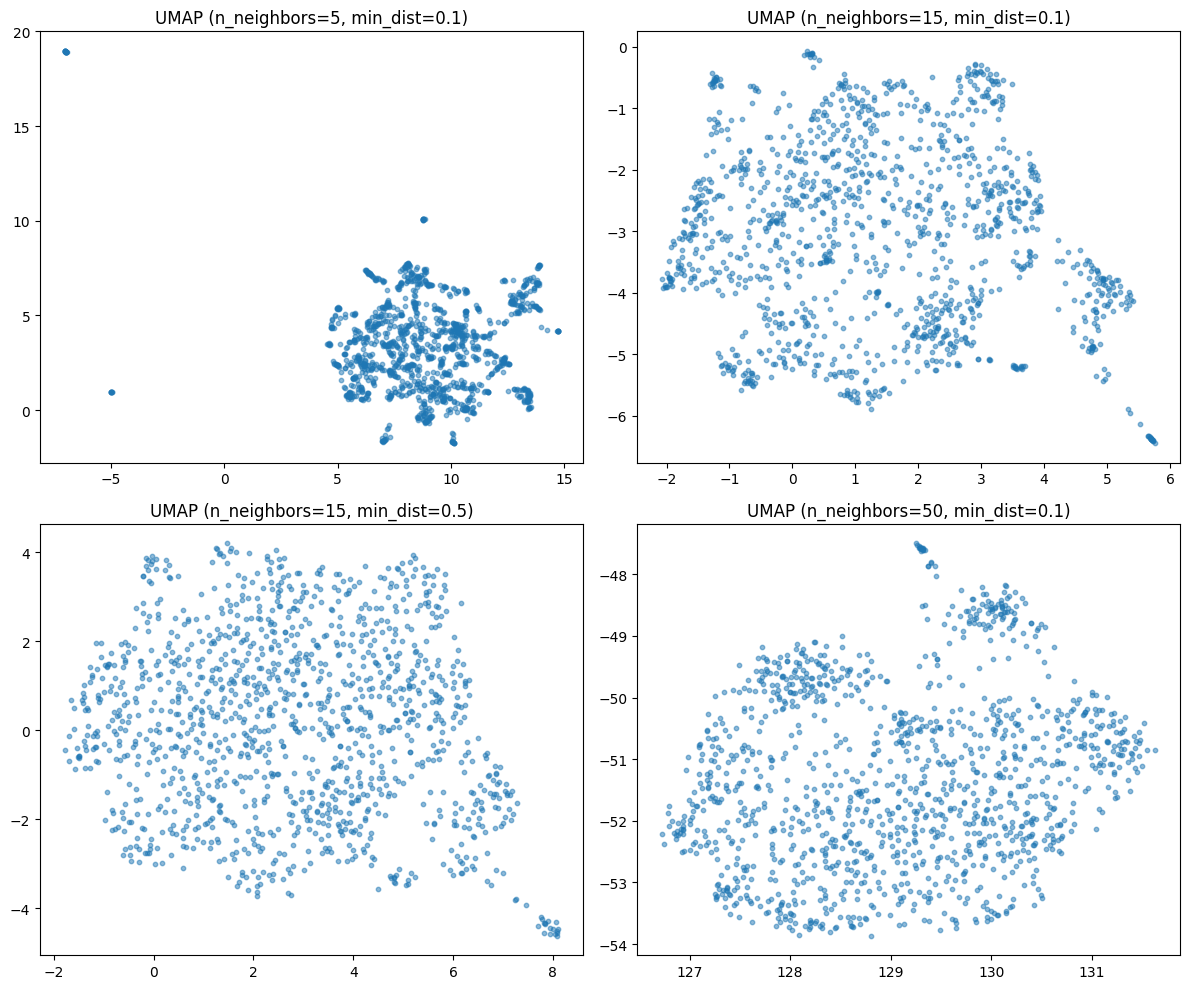

In [ ]:
import warnings
warnings.filterwarnings('ignore')  #ignores all the warnings and creating a combination with hyperparameter  n_neighbour and min_dist
combinations = [(5, 0.1), (15, 0.1), (15, 0.5), (50, 0.1)]
umap_projections = {}
#Setting up the 4 pannel graph and then representing them and drawing insights 
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
#Looping through the each of the group setting and running the UMAP
for ax, (n_neighbors, min_dist) in zip(axes.flatten(), combinations):
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = reducer.fit_transform(title_embeddings_std)
    umap_projections[f'{n_neighbors}_{min_dist}'] = embedding
    ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5, s=10)
    ax.set_title(f'UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})')
plt.tight_layout()
plt.show()
best_umap_embedding = umap_projections['15_0.1']


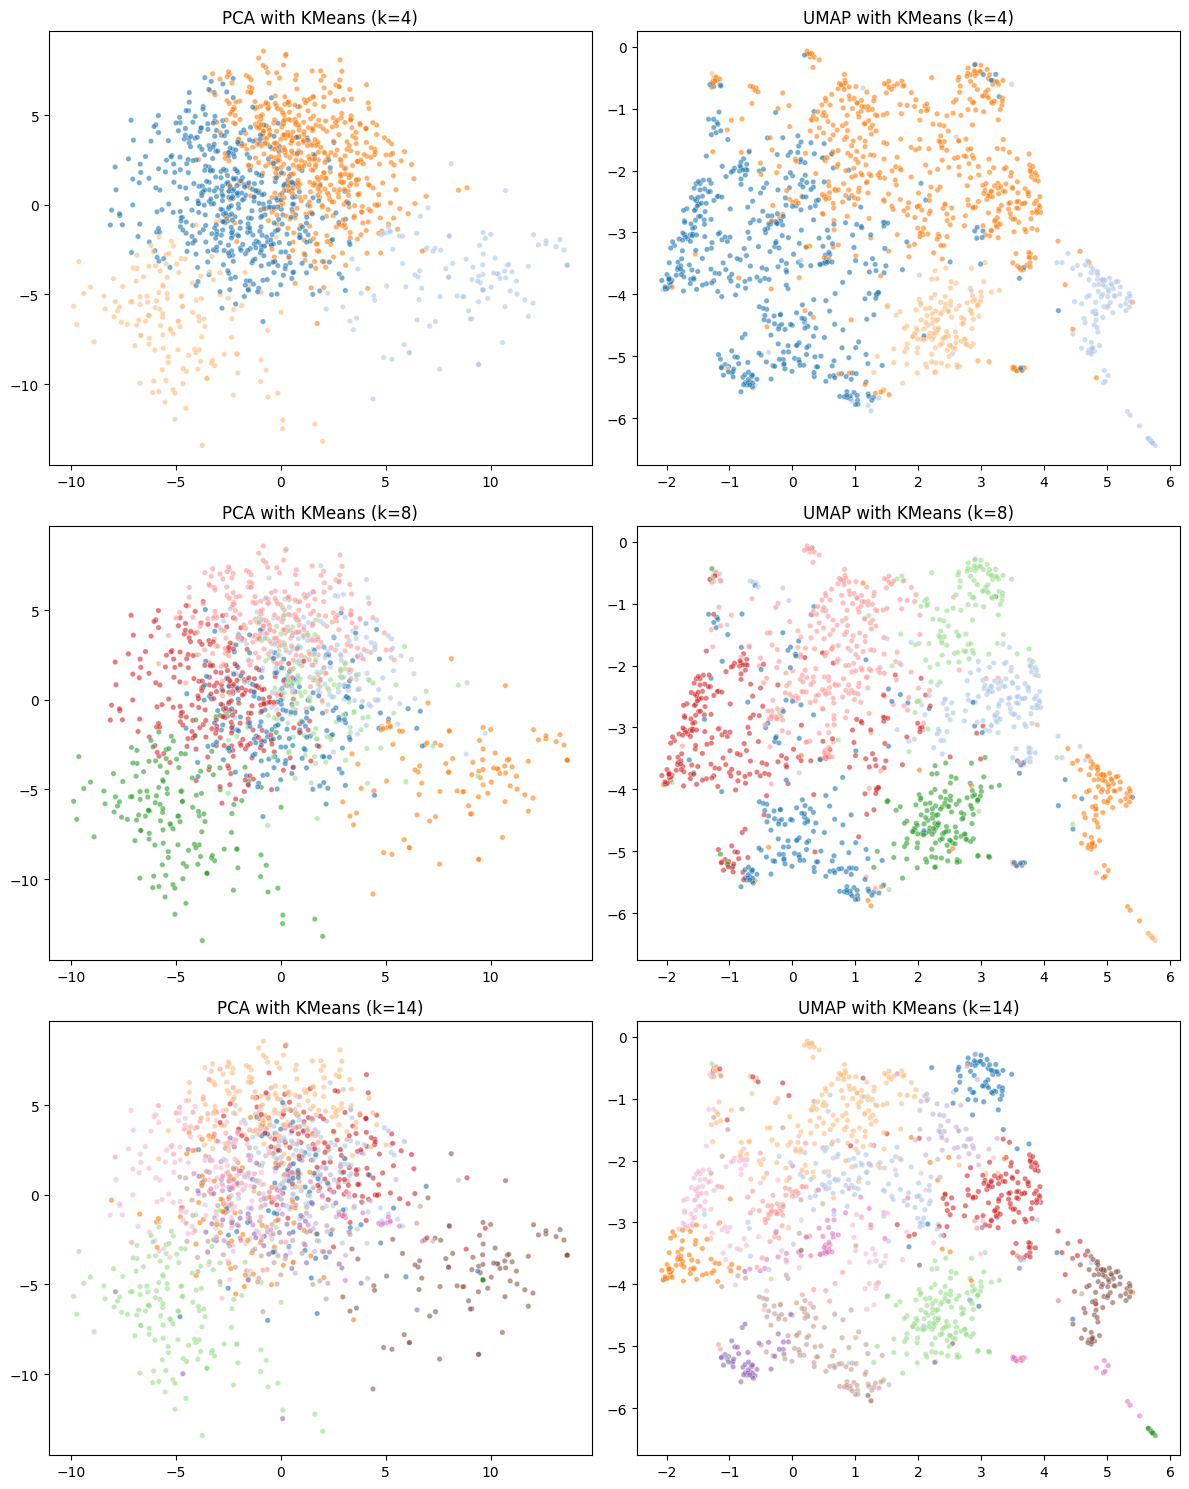

In [ ]:
# Running KMeans on the full-dimensional (standardized) title embeddings for k = 2 to 21.
# Picked 3-4 representative values of k and visualizing those clusterings on both the PCA and UMAP projections.
ks = range(2, 21)
kmeans_models = {}
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(title_embeddings_std)
    kmeans_models[k] = kmeans
rep_ks = [4, 8, 14]
fig, axes = plt.subplots(len(rep_ks), 2, figsize=(12, 5 * len(rep_ks)))
for i, k in enumerate(rep_ks):
    labels = kmeans_models[k].labels_
    ax_pca = axes[i, 0]
    #plotting the PCA graph
    sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=labels, palette='tab20', alpha=0.6, s=15, ax=ax_pca, legend=False)
    ax_pca.set_title(f'PCA with KMeans (k={k})')
    ax_umap = axes[i, 1]
    #plotting the UMAp
    sns.scatterplot(x=best_umap_embedding[:, 0], y=best_umap_embedding[:, 1], hue=labels, palette='tab20', alpha=0.6, s=15, ax=ax_umap, legend=False)
    ax_umap.set_title(f'UMAP with KMeans (k={k})')
plt.tight_layout()
plt.show()


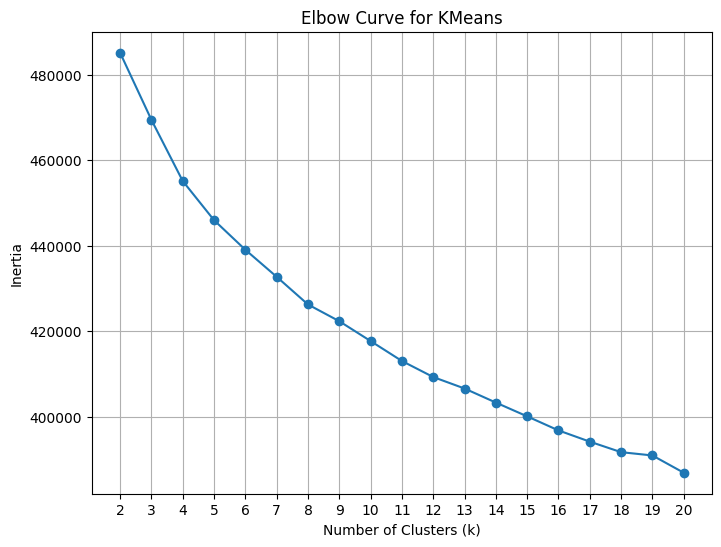

In [ ]:
#Plotting the elbow curve for KMeans to determine the optimal number of clusters.
#Gathering all the intertia scores
inertias = [kmeans_models[k].inertia_ for k in ks]
#plotting the graphs 
# plt.figure(figsize=(8, 6))
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Curve for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.grid(True)
plt.show()


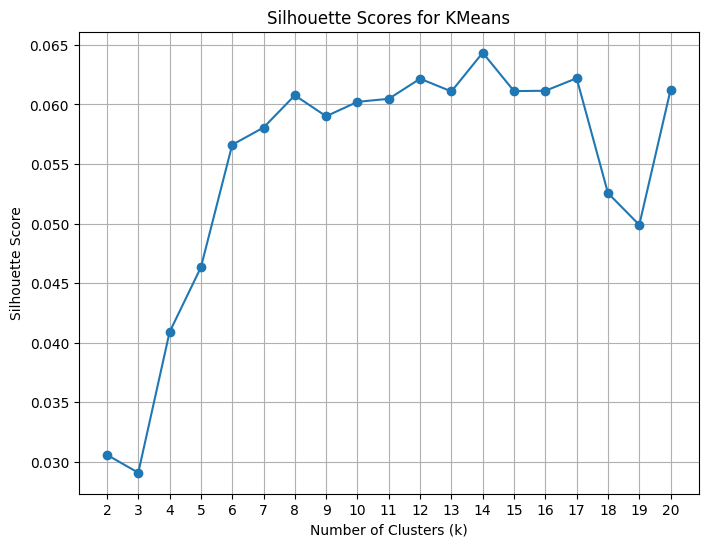

In [ ]:
#Reviewed the scikit-learn documentation for silhouette_score and plotted the silhouette scores for different values of k to determine the optimal number of clusters.
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(title_embeddings_std, kmeans_models[k].labels_) for k in ks]
plt.figure(figsize=(8, 6))
plt.plot(ks, silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks)
plt.grid(True)
plt.show()


Answer the following questions:

1. Do you think the PCA or UMAP dimensionality reduction technique is more appropriate for _visualization_ of this dataset? Why?
2. Based on the elbow method, what is the optimal number of clusters for this dataset? Explain how you arrived at your answer.
3. Based on the silhouette scores, what is the optimal number of clusters for this dataset? Explain how you arrived at your answer. **Note:** Don't be surprised if the silhouette scores are very low — this is common for high-dimensional text embeddings where clusters overlap significantly. If that's the case, discuss what the low scores tell you about the structure of the data.

**Answers:**

1. UMAP is definitely more appropriate for visualizing this text dataset. The text embeddings represent complex relationships between words, meaning the data points share many subtle, overlapping connections. PCA is a linear technique that tries to capture the biggest overall differences in the data, which just results in a massive, blurry cloud where everything overlaps. UMAP focuses on preserving the local neighborhoods (keeping similar documents close together), which allows it to untangle the complex web of words and reveal actual distinct clumps and clusters that we can see with our eyes. 
2.  Based on the elbow curve, the optimal number of clusters is likely between 6 and 8.  The elbow method graph plots the Inertia (how tightly packed the clusters are) as we increase the number of clusters (k). We are looking for the point where adding more clusters stops giving us major improvements in tightness (the "bend" in the arm). On our graph, the line plunges steeply from k=2 and then begins to level out noticeably into a more gradual slope around the k=6 to k=8 mark. Past that point, adding more clusters only gives marginal benefits.
3. According to the highest point on the silhouette score graph, the optimal number of clusters is k=14.  The silhouette score measures how well-separated the clusters are from each other, with higher scores being better. The graph peaks at k=14. However, the absolute maximum score achieved at that peak is extremely low (only 0.064 out of a possible 1.0). A score close to 0 indicates that the items sit right on the boundary line between two clusters. This tells us a profound truth about our legislative bill data: the clusters are highly overlapping and not well-separated. Because bills share heavy formal vocabulary and tackle interconnected topics, very few bills exist on isolated islands. Instead, they form a dense, continuous web of related tex
